# Explorador de um mapa - Observando diferentes regiões

## Imports & Setups

In [6]:
import os, json, math, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

# Imports do pacote do projeto
from gcm.core import Config, GloballyCoupledMaps
from gcm.maps import bistable_intervals, sync_boundaries
from gcm.metrics import sigma as sigma_metric, spins, magnetization

# Paleta (igual pedida)
COL_NON_SYNC  = "#e09f3e"   # não sincronizado
COL_SYNC_STAT = "#335c67"   # síncrono estacionário
COL_SYNC_CHAOS= "#9fd356"   # síncrono caótico
COL_ESCAPE    = "#9e2a2b"   # escape

FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

MU_MAIN = 1.9     # μ do artigo (biestável e caótico local)
I_TRACKS = [0, 1, 2, 3]  # índices que vamos olhar nos exemplos com múltiplas trajetórias

def fprime_piecewise(x, mu):
    """Derivada do mapa por partes: μ no miolo (|x|<1/3), -μ nas abas."""
    x = np.asarray(x)
    return np.where(np.abs(x) < 1.0/3.0, mu, -mu)

def estimate_lambda_time_series(x_series, mu):
    """Estimativa de λ_local via média temporal de ln|f'(x_t)| para uma série 1D."""
    fp = fprime_piecewise(x_series, mu)
    return float(np.mean(np.log(np.abs(fp))))

def shade_Ipm(ax, mu, alpha=0.12):
    """Sombras das bandas I_- e I_+ quando 1<μ<2 (apoio visual)."""
    if 1.0 < abs(mu) < 2.0:
        (imin, imax), (jmin, jmax) = bistable_intervals(mu)
        ax.axhspan(imin, imax, alpha=alpha, color="k")
        ax.axhspan(jmin, jmax, alpha=alpha, color="k")

def annotate_lambda(ax, mu, lam_est, xy=(0.02, 0.98)):
    lam_theory = math.log(abs(mu))
    txt = rf"$\lambda_{{\rm teórico}}=\ln|\mu|={lam_theory:.3f}$"+"\n"+rf"$\lambda_{{\rm estimado}}={lam_est:.3f}$"
    ax.text(xy[0], xy[1], txt, transform=ax.transAxes, ha="left", va="top",
            fontsize=11, bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, boxstyle="round,pad=0.25"))

def run_custom_init(mu, eps, x0, T_burn=0, T_meas=400, seed=0):
    """Roda o sistema começando de um vetor x0 dado (bypass do reset). Retorna (traj, sys)."""
    cfg = Config(N=len(x0), eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.x = np.array(x0, dtype=float)
    if T_burn>0:
        sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys

def run_with_ic(mu, eps, N=512, init="half_half", T_burn=600, T_meas=600, seed=0):
    """Roda com um init padrão do core; retorna (traj, sys)."""
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init=init)
    sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys

## Parte A - Síncrono estacionário ($\mu$=0.8)

> Dois mapas $x_i(t)$ com diferentes condições iniciais convergem para o mesmo valor fixo (teoricamente). Observamos isso na simulação e comparamos $\lambda$ teórico e estimado.

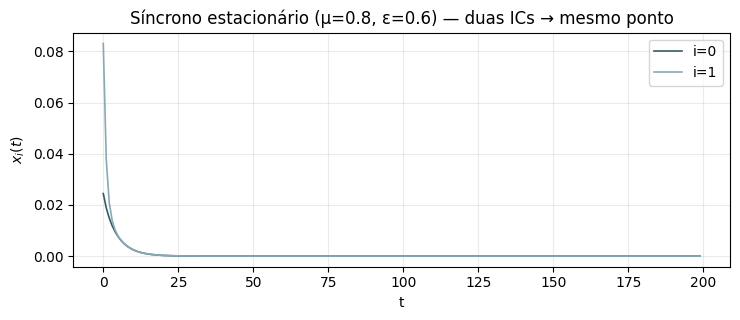

182

In [15]:
MU_STAT = 0.8           # |μ|<1 → estacionário
EPS_STAT = 0.6          # dentro da banda (para μ=0.8, ε∈(0,1] já sincroniza)
N = 64
# ICs: dois pontos bem diferentes; o restante distribuído (não importa muito aqui)
x0 = np.random.default_rng(42).uniform(-1, 1, size=N)
x0[0] = -0.7
x0[1] =  0.45

traj, sys = run_custom_init(mu=MU_STAT, eps=EPS_STAT, x0=x0, T_burn=0, T_meas=200, seed=123)
ts0, ts1 = traj[:,0], traj[:,1]

fig, ax = plt.subplots(figsize=(7.5,3.3))
ax.plot(ts0, lw=1.2, color=COL_SYNC_STAT, label="i=0")
ax.plot(ts1, lw=1.2, color="#89a9b4", label="i=1")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$")
ax.set_title(rf"Síncrono estacionário (μ={MU_STAT}, ε={EPS_STAT}) — duas ICs → mesmo ponto")
ax.grid(alpha=0.25); ax.legend()

lam_est = estimate_lambda_time_series(ts0, MU_STAT)
#annotate_lambda(ax, MU_STAT, lam_est)
fig.tight_layout(); fig.savefig(FIGS/"A_sync_estacionario_duas_ICs.png", dpi=180); plt.show()

# salva stats
(DATA/"A_sync_estacionario_stats.json").write_text(
    json.dumps({"mu":MU_STAT,"eps":EPS_STAT,
                "x0_final": float(ts0[-1]), "x1_final": float(ts1[-1]),
                "lambda_theory": math.log(abs(MU_STAT)), "lambda_est": lam_est}, indent=2),
    encoding="utf-8")


**Leitura rápida:** Como $\mu <1$, o mapa local contrai (também é levado a 0). Dentro dessa banda de sincronização, as diferenças transversas somem e todos caem no mesmo ponto que é $x*=0$, visto acima. Ou seja, para qualquer condição inicial que dermos vamos ver eles caindo no mesmo lugar. [Fazer diferentes condições iniciais].

## Parte B -- Síncrono caótico ($\mu=1.9$)

> Mostramos duas execuções com $\varepsilon$ na banda **sincronizada** de forma que observemos os dois atratores $I_+$ e $I_-$ (todos sincronizando em um atrator caótico). 

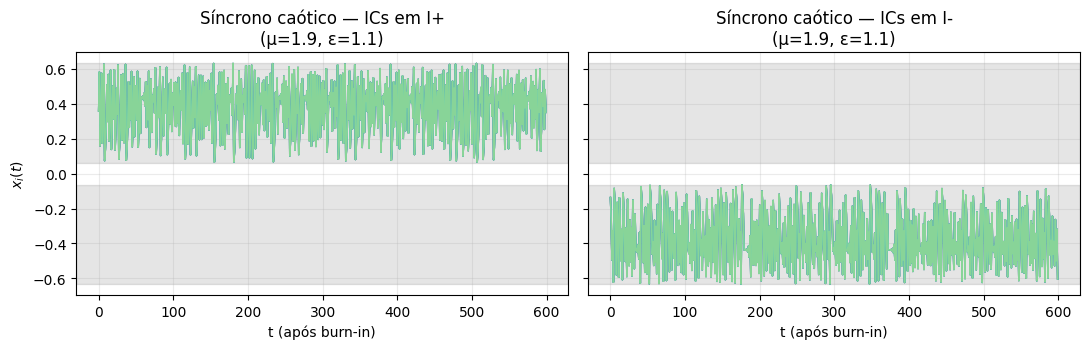

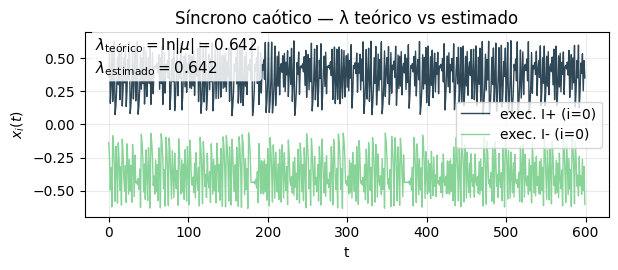

151

In [19]:
MU = MU_MAIN
EPS_SC = 1.1     # dentro da banda [~0.473, 1.526] para μ=1.9
N = 512
T_BURN, T_MEAS = 400, 600

# Gera ICs todas em I+ ou todas em I- (para mostrar que ambos atratores são possíveis)
i_minus, i_plus = bistable_intervals(MU)

def sample_from_interval(interval, size, seed=0):
    rng = np.random.default_rng(seed)
    return rng.uniform(interval[0], interval[1], size=size)

# Execução 1: ICs em I+
x0_plus = sample_from_interval(i_plus, N, seed=1)
traj_plus, sys_plus = run_custom_init(mu=MU, eps=EPS_SC, x0=x0_plus, T_burn=T_BURN, T_meas=T_MEAS, seed=1001)

# Execução 2: ICs em I-
x0_minus = sample_from_interval(i_minus, N, seed=2)
traj_minus, sys_minus = run_custom_init(mu=MU, eps=EPS_SC, x0=x0_minus, T_burn=T_BURN, T_meas=T_MEAS, seed=1002)

# Plot 4 séries em cada execução
fig, axes = plt.subplots(1,2, figsize=(11,3.6), sharey=True)
for k, ax in enumerate(axes):
    tr = traj_plus if k==0 else traj_minus
    label = "ICs em I+" if k==0 else "ICs em I-"
    col   = COL_SYNC_CHAOS
    for idx,c in zip(I_TRACKS, ["#2f4858","#33658a","#55dde0","#88d498"]):
        ax.plot(tr[:, idx], lw=1.1, color=c)
    shade_Ipm(ax, MU, alpha=0.10)
    ax.set_xlabel("t (após burn-in)"); 
    if k==0: ax.set_ylabel(r"$x_i(t)$")
    ax.set_title(f"Síncrono caótico — {label}\n(μ={MU}, ε={EPS_SC})")
    ax.grid(alpha=0.25)

plt.tight_layout(); plt.savefig(FIGS/"B_sync_caotico_quatro_series.png", dpi=180); plt.show()

# λ estimado (pega uma série de cada execução)
lam_plus  = estimate_lambda_time_series(traj_plus[:,0],  MU)
lam_minus = estimate_lambda_time_series(traj_minus[:,0], MU)

# Anexo: um gráfico pequeno anotando λ
fig, ax = plt.subplots(figsize=(6.2,2.8))
ax.plot(traj_plus[:,0],  lw=1.0, color="#2f4858", label="exec. I+ (i=0)")
ax.plot(traj_minus[:,0], lw=1.0, color="#88d498", label="exec. I- (i=0)")
annotate_lambda(ax, MU, 0.5*(lam_plus+lam_minus))
ax.set_title("Síncrono caótico — λ teórico vs estimado")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$"); ax.grid(alpha=0.25); ax.legend()
fig.tight_layout(); fig.savefig(FIGS/"B_sync_caotico_lambda.png", dpi=170); plt.show()

(DATA/"B_sync_caotico_stats.json").write_text(
    json.dumps({"mu":MU, "eps":EPS_SC, 
                "lambda_theory": math.log(abs(MU)),
                "lambda_est_plus": lam_plus, "lambda_est_minus": lam_minus}, indent=2),
    encoding="utf-8")


**Por que dois atratores?** Para $ |\mu |>1$ e dentro da banda síncrona, o mapa local é **biestável** como vimos acima. Existem dois atratores $I_{\pm}$. O acoplamento global é forte o bastante para sincronizar todas as trajetórias colam na mesma órbita -- mas essa órbita pode residir em $I_{+}$ ou em $I_{-}$ dependendo do viés inicial - Em nossa analogia imagine que um canal de TV já era mais popular logo de ínicio (campo médio "escolhe o lado").

In [7]:
# Lyapunov local (checagem numérica)

# Derivada por partes: mu no miolo |x|<1/3, -mu nas abas

def fp(x, mu):
    return np.where(np.abs(x) < 1.0/3.0, mu, -mu)

lts = {}
for eps, y in traces.items():
    # aproxima λ_local por média temporal de ln|f'(x_t)|
    lam = float(np.mean(np.log(np.abs(fp(y, MU)))))
    lts[eps] = lam

print("λ_local teórico = ln|μ| =", np.log(abs(MU)))
print("Estimativas por ε:", lts)
(DATA/"finite_time_lyapunov_single_index.json").write_text(json.dumps({str(k): v for k,v in lts.items()}), encoding="utf-8")

λ_local teórico = ln|μ| = 0.6418538861723947
Estimativas por ε: {0.2: 0.6418538861723946, 0.7: 0.6418538861723946, 1.1: 0.6418538861723946, 1.6: 0.6418538861723946}


108

<function matplotlib.pyplot.show(close=None, block=None)>

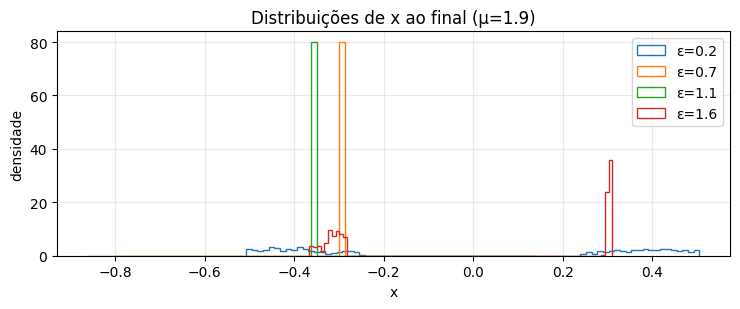

In [8]:
# Histogramas finais de x para comparar regimes
fig, ax = plt.subplots(figsize=(7.5,3.2))
for eps, x in final_x.items():
    ax.hist(x, bins=80, histtype='step', density=True, label=f"ε={eps}")
ax.set_xlabel("x"); ax.set_ylabel("densidade")
ax.set_title(f"Distribuições de x ao final (μ={MU})")
ax.grid(alpha=0.25); ax.legend()
fig.tight_layout(); fig.savefig(FIGS/"Hist_x_final_mu1.9.png", dpi=180); 
plt.show #plt.close(fig)
